In [86]:
import pyspark
from pyspark.sql.functions import *
import wrangle
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.ion()
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=14)
plt.style.use('ggplot')

import re

In [4]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()


df= wrangle.wrangle_311(spark)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


1. How many different cases are there, by department?

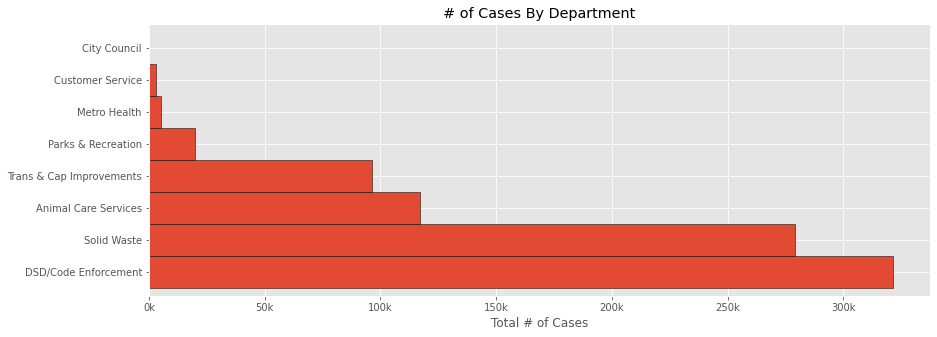

In [21]:
def format_number(x, *args):
    return "{:.0f}k".format(x / 1000)

(
df.groupBy('department')
    .count()
    .sort(desc('count'))
    .toPandas()
    .set_index('department')['count']
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)
plt.gca().set(
    ylabel="", xlabel="Total # of Cases", title="# of Cases By Department"
)
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_number))

2. Does the percentage of cases that are late vary by department?

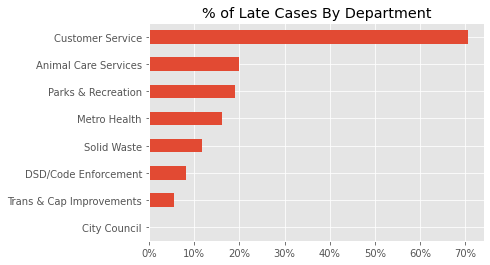

In [63]:
(
df.withColumn('case_late', col('case_late').cast('int'))
    .groupBy('department')
    .agg(avg('case_late').alias('percent_late'))
    .sort('percent_late')
    .toPandas()
    .set_index('department')['percent_late']
    .plot.barh()
)

plt.gca().set(
    ylabel="", xlabel="", title="% of Late Cases By Department"
)
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter("{:.0%}".format))

3.  On average, how late are the late cases by department?

[Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Avg Days Late Cases By Department')]

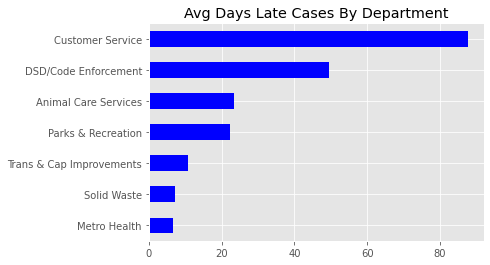

In [76]:
(
    df.filter(df.case_late == 'true')
    .groupBy('department')
    .agg(avg('num_days_late').alias('avg_days_late'))
    .toPandas()
    .set_index('department')['avg_days_late']
    .sort_values()
    .plot.barh(color='blue')
)
plt.gca().set(
    ylabel="", xlabel="", title="Avg Days Late Cases By Department"
    
)

4. What is the service type that is the most late? Just for Parks & Rec?

[Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Avg Days Late by Request Type for Parks and Rec')]

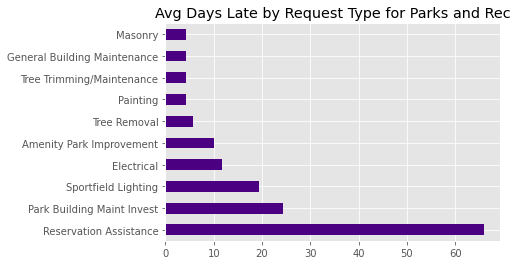

In [83]:
(
    df.filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type')
    .agg(avg('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .limit(10)
    .toPandas()
    .set_index('service_request_type')['avg_days_late']
    .plot.barh(color='indigo')
)
plt.gca().set(
    ylabel="", xlabel="", title=  "Avg Days Late by Request Type for Parks and Rec"
    
)

5 For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

[Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Avg Days Late by Request Type for DSD/Code Enforcement')]

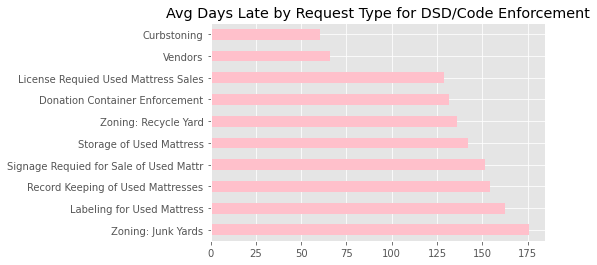

In [85]:
(
df.filter(col('department') == 'DSD/Code Enforcement')
    .groupBy('service_request_type')
    .agg(avg('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .limit(10)
    .toPandas()
    .set_index('service_request_type')['avg_days_late']
    .plot.barh(color='pink')
)

plt.gca().set(
    ylabel="", xlabel="", title=  "Avg Days Late by Request Type for DSD/Code Enforcement"
    
)

6.  Does whether or not its a weekend matter for when a case is opened/closed?

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

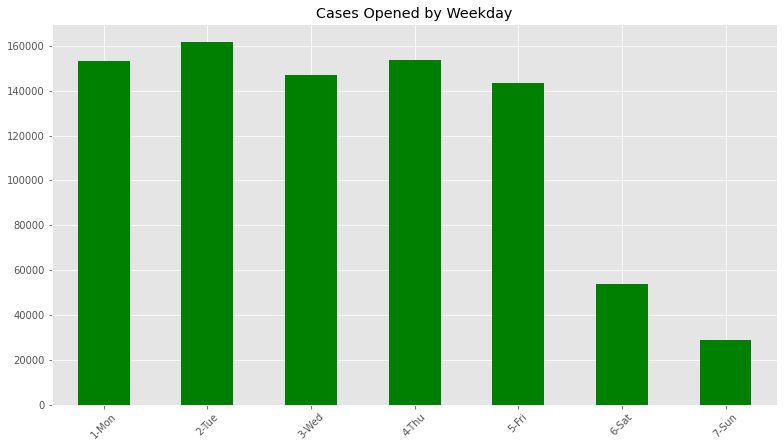

In [157]:
(
df.withColumn('weekday', date_format('case_opened_date', 'u-E'))
    .groupBy('weekday')
    .agg(count('weekday').alias('cases_opened'))
    .dropna()
    .sort('weekday')
    .toPandas()
    .set_index('weekday')['cases_opened']
    .plot.bar(color='green')
)

plt.gca().set(
    ylabel="", xlabel="", title=  "Cases Opened by Weekday"
)

plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

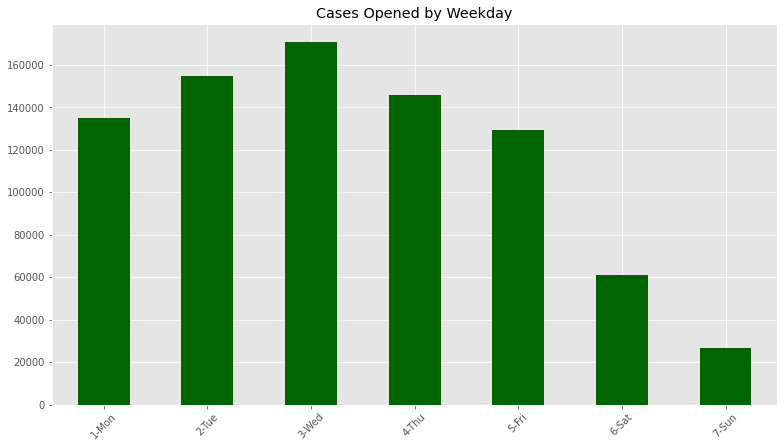

In [158]:
(
df.withColumn('weekday', date_format('case_closed_date', 'u-E'))
    .groupBy('weekday')
    .agg(count('weekday').alias('cases_closed'))
    .dropna()
    .sort('weekday')
    .toPandas()
    .set_index('weekday')['cases_closed']
    .plot.bar(color='darkgreen')
)

plt.gca().set(
    ylabel="", xlabel="", title=  "Cases Opened by Weekday"
)

plt.xticks(rotation=45)

7. On average, how many cases are opened a day for the Customer Service department?

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

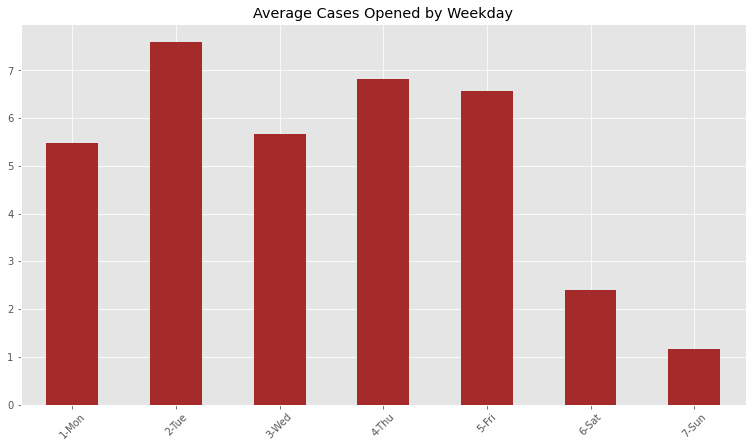

In [214]:
df_7 = (
    df.filter(col('department') == 'Customer Service') 
    .withColumn('weekday', date_format('case_opened_date', 'u-E'))
    .withColumn('date', date_format('case_opened_date', 'yyyy-MM-dd'))
    .groupBy('date')
    .agg(count('date').alias('cases_by_day'))
)

(
df_7.withColumn('weekday', date_format(to_date(col('date')), 'u-E'))
    .groupBy('weekday')
    .agg(avg('cases_by_day').alias('cases_opened'))
    .dropna()
    .sort('weekday')
    .toPandas()
    .set_index('weekday')['cases_opened']
    .plot.bar(color='brown')
)

plt.gca().set(
    ylabel="", xlabel="", title=  "Average Cases Opened by Weekday"
)

plt.xticks(rotation=45)